# Classification of short videos

In [1]:
import numpy as np

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import ConvLSTM2D, Dropout, Conv2D, GlobalAveragePooling2D, Dense, Dropout

import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

2026-02-02 00:05:00.033236: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-02 00:05:00.126665: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import matplotlib.pyplot as plt
from keras.optimizers import SGD


In [3]:
import sklearn
import tensorflow

print(np.__version__) # 1.26.4
print(sklearn.__version__) # 1.5.1
print(tensorflow.__version__)  # 2.13.1


1.26.4
1.5.1
2.13.1


In [4]:
# Use fixed seeds for random generator.
# from numpy.random import seed 

# seed(42)
# tensorflow.random.set_seed(42)

tensorflow.keras.utils.set_random_seed(42)

* (a)  **data_dir** <- folder with the videos.

* (b)  **img_height, img_width** <- 50 (new dimensions of images, can be increased so that the model gets more data).

* (c)  **seq_len** <- 15 (num frames per video).

Exploratory Analysis shows that videos are at of 90 frames at least. The 15 frames is updated so that it's regular and covers (more or less) the common initial interval.

* (d)  **classes** <- "ApplyEyeMakeup" , "ApplyLipstick"


In [5]:
# (a)
data_dir = "data/"

# (b) reshape to square images
img_height = img_width = 50

# (c)
seq_len = 15

period = 6 # period of frame sampling
residue = 0 # customization, unlikely to be important here.
frames_to_consider = seq_len * period
# frames_to_extract = range(residue, frames_to_consider, period)
frames_to_extract = list(range(residue, frames_to_consider, period))

# print(f"Frames to consider: {frames_to_consider}")
print(f"Indices of frames to be used in model: {frames_to_extract}")


# (d)
classes = ("ApplyEyeMakeup", "ApplyLipstick")

Indices of frames to be used in model: [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84]


* (e) The function <code>frame_extraction</code> .
    * uses the library class <code>cv2.VideoCapture</code>;
    * processes **seq_len** first images from the video, reshapes then appends to the output list.


In [6]:
# (f)
def frames_extraction(video_path: str) -> list:
    """ Get frames from a video.
    
    Args:
        video_path (str): path to video
    
    Input global variables:
        img_width, img_height (int)
        frames_to_extract (range or list of int)
    
    Raises:
        EOFError: video is shorter than 'seq_len' frames

    Returns:
        list[np.ndarray ?]: video converted to 4d tensor
        
    Returns frames with periodic sampling.
    """
    
    frames_list = []

    vidObj = cv2.VideoCapture(video_path)
    # An instance VideoCapture
    # https://www.scaler.com/topics/cv2-videocapture/

    for n_frame in range(frames_to_extract[-1] + 1):
    
        success, image = vidObj.read() # Read images 1-by-1
        
        if success and (n_frame in frames_to_extract):
            
            # Using OpenCV, reshape the image 
            img_reshaped: np.ndarray = cv2.resize(image, dsize=(img_width, img_height))
            
            # Append the frame to the list
            frames_list.append(img_reshaped)
            
        elif not success:
            # Print error messsage and exit the loop
            print(f"Failed to read the frame {n_frame} from the file {video_path}")
            raise EOFError

    return frames_list

Function <code>create_data</code> writes the dataset in the shape of  _array_.


Its output has the format used by an **ConvLSTM** in 5D. The features being pixels of a frame, we keep the image's encoding (3D) and sack the images as a tensor **(N_samples, N_timesteps, N_width, N_height, N_channel)** .

In [7]:
def create_dataset(input_dir: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Write an array with all images of each video
    and the corresponding labels.

    Input:
        input_dir (str): path to folder with the videos.

    Input global variable: classes: iterable[str]
    Input global variables for 'frames_extraction':
        img_width, img_height, seq_len (int)
    
    Returns formatted dataset:
        X (np.ndarray : (N_samples, N_timesteps, N_width, N_height, N_channel));
        Y (np.ndarray : (N_samples, N_classes))
    
    This function can be sped up by pre-allocating numpy arrays.
    """
    X = []
    Y = []

    for c in classes:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        # list[str] : list of file names in the folder.
        # It's assumed the following loop that all files are videos.
        
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            # frames: list of frames.
            
            if len(frames) == seq_len:
                X.append(frames)

                y = [0]*len(classes)
                y[classes.index(c)] = 1
                # list.index :
                # https://docs.python.org/3/tutorial/datastructures.html#more-on-lists
                
                Y.append(y)
                # y (list of 0es and 1es of length len(classes)):
                # the one-hot encoding of the index of file.

    # convert X, Y to tensor and matrix respectively.
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

* (g)  X et y <- function **create_data** .

* (h) Split te data into X_train , X_test , y_train , y_test using the test set with 30% of data.

* (i) Print the shapes of these arrays.

In [8]:
# (g)
X, y = create_dataset(data_dir)

# (h)
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# (i)
print(type(X_train))  # ndarray
print(X_train.shape)  # (181, 15, 50, 50, 3)
print(X_test.shape)  # (78, 15, 50, 50, 3)

print(y_train.shape)  # (181, 2)
print(y_test.shape)  # (78, 2)

ApplyEyeMakeup


ApplyLipstick
<class 'numpy.ndarray'>
(181, 15, 50, 50, 3)
(78, 15, 50, 50, 3)
(181, 2)
(78, 2)


(j) Display the first and the last image from a sequence of X_train.

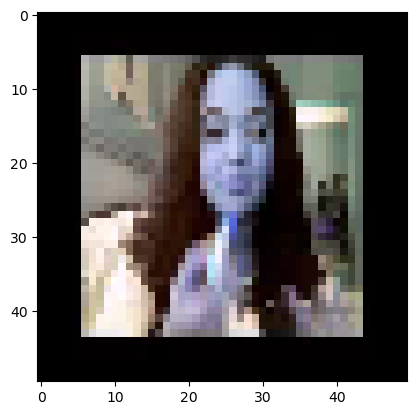

In [9]:
plt.imshow(X_train[0, 0, :, :, :])

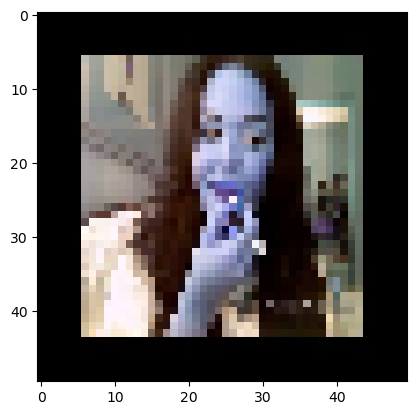

In [10]:
plt.imshow(X_train[0, -1, :, :, :])

Remark: low image resolution + short sequence can hinder the performance.

Define a model of type CNN-LSTM using the layer **ConvLSTM2D** in Keras.

The parameter <code>data_format = "chanels_last"</code> specifies that the "channels" describe color in the format RGB and are stored in the last dimension .

In [11]:
# (k)
model = Sequential()

model.add(ConvLSTM2D(
    filters=64,
    kernel_size=(3,3),
    input_shape=X_train.shape[1:], # (timesteps, width, height, channels)
    name='ConvLSTM'))
# {ConvLSTM -> conv}

model.add(Dropout(0.2))

model.add(Conv2D(filters=128,
                kernel_size=(3,3),
                data_format="channels_last",
                padding="valid",
                name="conv"))

model.add(GlobalAveragePooling2D())
# conv -> dense

model.add(Dense(256, activation="relu", name='dense_256'))

model.add(Dropout(0.3, seed=42))

model.add(Dense(2, activation='softmax', name='output'))

In [12]:
"""
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 ConvLSTM (ConvLSTM2D)       (None, 48, 48, 64)        154624    
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv (Conv2D)               (None, 46, 46, 128)       73856     
                                                                 
 global_average_pooling2d (  (None, 128)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_256 (Dense)           (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 output (Dense)              (None, 2)                 514       
                                                                 
=================================================================
Total params: 262018 (1023.51 KB)
Trainable params: 262018 (1023.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
"""

# (l)
print(model.summary())
# 262000 parameters, all trainable

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ConvLSTM (ConvLSTM2D)       (None, 48, 48, 64)        154624    
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv (Conv2D)               (None, 46, 46, 128)       73856     
                                                                 
 global_average_pooling2d (  (None, 128)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_256 (Dense)           (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [13]:
# (m)
optim_SGD = SGD(learning_rate=0.001)
# https://keras.io/api/optimizers/sgd/

In [14]:
# (n)
model.compile(optimizer=optim_SGD,  # Keras optimiser of kind _Stochastic Gradient Descent_
                loss="categorical_crossentropy",  # cost function adapted for  multiclass classification
                metrics=['acc'])  # metrics of model _accuracy_

In [15]:
# Train the model over 10 epochs with batch size 8, without validation set.
batch_size = 8
epochs = 10
model_history = model.fit(
            x=X_train,
            y=y_train,
            batch_size=batch_size,
            epochs = epochs,
            verbose=True)

# 10min on my local machine


Epoch 1/10
23/23 [==============================] - 78s 3s/step - loss: 0.7325 - acc: 0.4586
Epoch 2/10
23/23 [==============================] - 66s 3s/step - loss: 0.6968 - acc: 0.5193
Epoch 3/10
23/23 [==============================] - 66s 3s/step - loss: 0.6910 - acc: 0.5580
Epoch 4/10
23/23 [==============================] - 66s 3s/step - loss: 0.6943 - acc: 0.5580
Epoch 5/10
23/23 [==============================] - 65s 3s/step - loss: 0.6898 - acc: 0.5635
Epoch 6/10
23/23 [==============================] - 65s 3s/step - loss: 0.6760 - acc: 0.6077
Epoch 7/10
23/23 [==============================] - 64s 3s/step - loss: 0.6845 - acc: 0.5856
Epoch 8/10
23/23 [==============================] - 63s 3s/step - loss: 0.6832 - acc: 0.5967
Epoch 9/10
23/23 [==============================] - 64s 3s/step - loss: 0.6830 - acc: 0.5691
Epoch 10/10
23/23 [==============================] - 63s 3s/step - loss: 0.6816 - acc: 0.5746


One can remark that the accuracy varies little after epochs 5-6.

* (p) Predict the probabilities pour X_test

* (q) keep only the  argmax using the corresponding function from numpy 

* (r) Print the classification report

In [16]:
# (p)
y_proba = model.predict(X_test)
print(type(y_proba))  # ndarray
print(y_proba.shape)  # (78, 2)

3/3 [==============================] - 7s 2s/step
<class 'numpy.ndarray'>
(78, 2)


In [17]:
# (q)
def pred_mat2class(pred_matrix):
    return pred_matrix.argmax(axis=1)


y_pred = pred_mat2class(y_proba)
y_test_cl = pred_mat2class(y_test)

print(y_pred[:10])  # [0 0 1 1 0 0 1 0 0 0] leads to a more accurate model
print(y_test_cl[:10])  # [0 0 0 0 0 0 1 1 0 1]

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 1 0 1]


In [18]:
print(y_test.shape)  # (78, 2)

(78, 2)


In [19]:
"""
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        46
           1       1.00      0.19      0.32        32

    accuracy                           0.67        78
   macro avg       0.82      0.59      0.55        78
weighted avg       0.79      0.67      0.59        78
"""

# (r)
print(classification_report(y_test_cl, y_pred))


              precision    recall  f1-score   support

           0       0.64      1.00      0.78        46
           1       1.00      0.19      0.32        32

    accuracy                           0.67        78
   macro avg       0.82      0.59      0.55        78
weighted avg       0.79      0.67      0.59        78



In [20]:
# Save the model
# model.save("models/model.keras")

Recall of the minority class is quite small, which means that the model still suffers from imbalanced classes:  the majority class 'ApplyEyeMakeup' is incorrectly predicted quite often.

The model can be improved using these ideas:
<ul>
    <li>subsample the majority class in the training set,</li> 
    <li>query the data on-the-fly rather than storing it in RAM (see below).</li>
    <li>preprocess the videos using Optical Flow.
    <li>check for overfitting, and whether the number of frames can be reduced, for 15 frames in 3 sec may be excessive.</li>
    
</ul>

# Take-away.

* The layer **ConvLSTM** of _Keras_ allows processing videos by combining  convolution with an architecture of more usual LSTM.

* The data in a **ConvLSTM** usually is 5D, the dimensions being <code>(N_samples, N_timesteps, N_width, N_height, N_channel)</code> .

* RAM can be optimised during the operation of cutting videos and image loading, using a custom generator. An example is presented [here](https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7).
